<a href="https://colab.research.google.com/github/rakeshnandithale/vae/blob/main/note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! curl -L -o celeba-dataset.zip https://www.kaggle.com/api/v1/datasets/download/jessicali9530/celeba-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1361M  100 1361M    0     0  96.5M      0  0:00:14  0:00:14 --:--:-- 84.0M


In [2]:
! unzip celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [3]:
import pandas as pd
import os
import shutil

In [4]:
# Paths
images_folder = "img_align_celeba/img_align_celeba"
partition_file = "list_eval_partition.csv"
train_folder = "train/"
val_folder = "val/"
test_folder = "test/"

# Create folders if not exists
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Load the partition data
partition_data = pd.read_csv(partition_file)

# Move images to respective folders
for _, row in partition_data.iterrows():
    image_id, partition = row['image_id'], row['partition']
    src_path = os.path.join(images_folder, image_id)

    if partition == 0:
        dest_path = os.path.join(train_folder, image_id)
    elif partition == 1:
        dest_path = os.path.join(val_folder, image_id)
    elif partition == 2:
        dest_path = os.path.join(test_folder, image_id)

    shutil.move(src_path, dest_path)

print("Dataset organized into train, val, and test folders.")


Dataset organized into train, val, and test folders.


In [5]:
# Paths
train_folder = "train/"
val_folder = "val/"
test_folder = "test/"

# Subfolder name for the class (e.g., "face")
class_name = "face"

# Create subfolders
os.makedirs(os.path.join(train_folder, class_name), exist_ok=True)
os.makedirs(os.path.join(val_folder, class_name), exist_ok=True)
os.makedirs(os.path.join(test_folder, class_name), exist_ok=True)

# Move images into subfolders
for folder in [train_folder, val_folder, test_folder]:
    for image in os.listdir(folder):
        if image.endswith(".jpg"):  # Ensure only image files are moved
            src = os.path.join(folder, image)
            dest = os.path.join(folder, class_name, image)
            shutil.move(src, dest)

print("Dataset organized into subfolders.")


Dataset organized into subfolders.


In [6]:
! pip install torch torchvision matplotlib

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [8]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # Output: 32x32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # Output: 64x16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),# Output: 128x8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)# Output: 256x4x4
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 256 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # Output: 128x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: 64x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # Output: 32x32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # Output: 3x64x64
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 256, 4, 4)
        x = self.deconv(x)
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) return mu + eps * std

    def forward(self, x):

In [9]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss


In [10]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load datasets
train_dataset = datasets.ImageFolder(root='train', transform=transform)
val_dataset = datasets.ImageFolder(root='val', transform=transform)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [11]:
# Hyperparameters
latent_dim = 128
learning_rate = 1e-3
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, optimizer, and loss
vae = VAE(latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss = vae_loss(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    vae.eval()
    val_loss = 0
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            recon_images, mu, logvar = vae(images)
            loss = vae_loss(recon_images, images, mu, logvar)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader.dataset):.4f}, Val Loss: {val_loss/len(val_loader.dataset):.4f}")

    # Save checkpoint
    torch.save(vae.state_dict(), f"vae_epoch_{epoch+1}.pth")


Epoch 1/20, Train Loss: 261.8762, Val Loss: 207.5245
Epoch 2/20, Train Loss: 201.4066, Val Loss: 198.2889
Epoch 3/20, Train Loss: 195.8990, Val Loss: 194.8499
Epoch 4/20, Train Loss: 193.0533, Val Loss: 194.2260
Epoch 5/20, Train Loss: 190.8711, Val Loss: 192.4191
Epoch 6/20, Train Loss: 189.4150, Val Loss: 191.5550
Epoch 7/20, Train Loss: 188.3355, Val Loss: 187.4247
Epoch 8/20, Train Loss: 187.5953, Val Loss: 187.3285
Epoch 9/20, Train Loss: 186.9709, Val Loss: 187.1612
Epoch 10/20, Train Loss: 186.4678, Val Loss: 190.8748
Epoch 11/20, Train Loss: 186.0104, Val Loss: 187.1028
Epoch 12/20, Train Loss: 185.6920, Val Loss: 188.6009
Epoch 13/20, Train Loss: 185.3352, Val Loss: 185.6556
Epoch 14/20, Train Loss: 185.0171, Val Loss: 184.8005
Epoch 15/20, Train Loss: 184.7176, Val Loss: 187.6289
Epoch 16/20, Train Loss: 184.5249, Val Loss: 184.7349
Epoch 17/20, Train Loss: 184.2788, Val Loss: 185.2538
Epoch 18/20, Train Loss: 184.1332, Val Loss: 190.8390
Epoch 19/20, Train Loss: 183.9569, Va

In [12]:
torch.save(vae.state_dict(), "vae_final.pth")


<ipython-input-19-85465eb81eb1>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load('vae_final.pth', map_location=device))


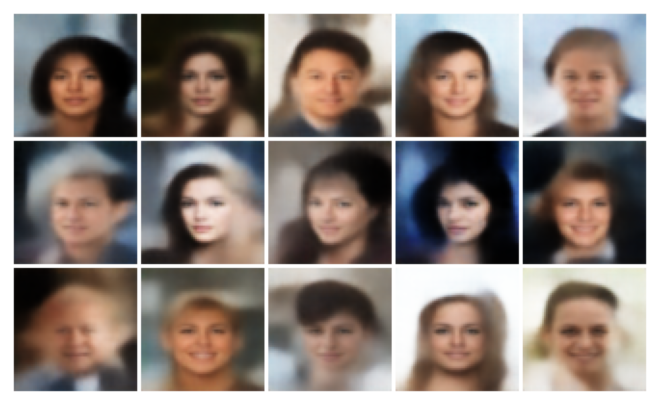

In [19]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Load the trained VAE model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim=128)  # Ensure latent_dim matches your trained model
vae.load_state_dict(torch.load('vae_final.pth', map_location=device))
vae.to(device)
vae.eval()

# Generate random latent vectors and decode them into images
def generate_new_images(vae, num_images=10):
    with torch.no_grad():
        z = torch.randn(num_images, 128).to(device)  # Sample latent vectors
        generated_images = vae.decoder(z)  # Decode latent vectors
    return generated_images

# Plot generated images
def plot_generated_images(images):
    images = images.cpu()
    grid = make_grid(images, nrow=5, normalize=True, pad_value=1)
    plt.figure(figsize=(15, 5))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Generate and plot new images
generated_images = generate_new_images(vae, num_images=15)
plot_generated_images(generated_images)


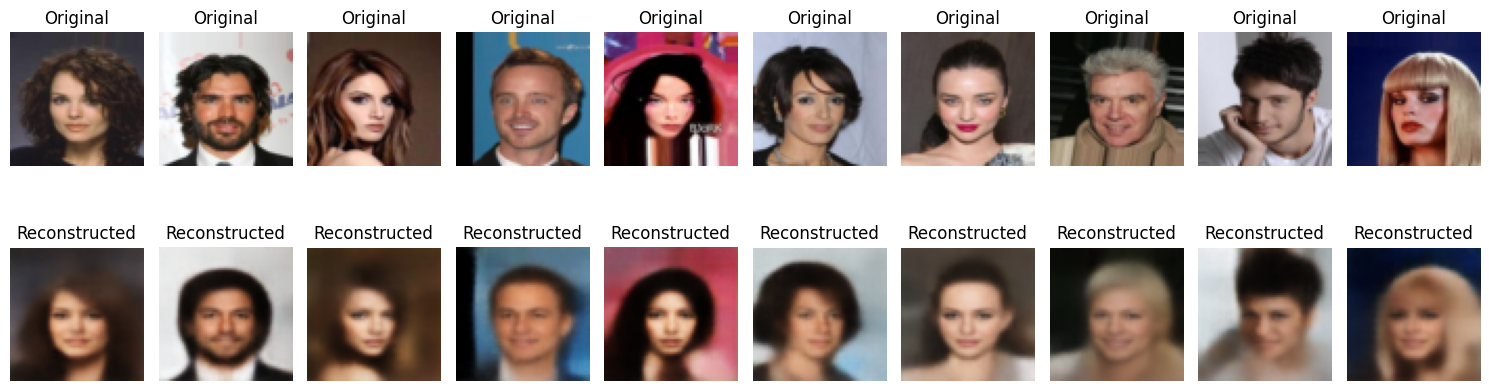

In [20]:
# Load a batch of images from the validation dataset
from torchvision.transforms import ToPILImage

def plot_original_vs_reconstructed(data_loader, vae, num_images=10):
    vae.eval()
    with torch.no_grad():
        data_iter = iter(data_loader)
        images, _ = next(data_iter)  # Load a batch of images
        images = images[:num_images].to(device)
        reconstructed_images, _, _ = vae(images)  # Reconstruct images

    images = images.cpu()
    reconstructed_images = reconstructed_images.cpu()

    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    for i in range(num_images):
        # Original images
        axes[0, i].imshow(ToPILImage()(images[i]))
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")
        # Reconstructed images
        axes[1, i].imshow(ToPILImage()(reconstructed_images[i]))
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")
    plt.tight_layout()
    plt.show()

# Assuming you have a data loader for the validation dataset
plot_original_vs_reconstructed(val_loader, vae, num_images=10)
